### **Data Preparation**
####  **1. Fetch Data from UCI Repository**
We will retrieve the dataset directly from the **UCI ML Repository** using `ucimlrepo`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from ucimlrepo import fetch_ucirepo

adult = fetch_ucirepo(id=2)
X_original = adult.data.features
y_original = adult.data.targets

####  **2. Data Preprocessing**
We will:
- Select **important features** (`age`, `education-num`, `sex`, `hours-per-week`, `marital-status`).
- Encode categorical variables.
- Standardize numerical features.

In [2]:
# Preparing selected features
X_age = np.array(X_original)[:20000, 0]  # age
X_edu = np.array(X_original)[:20000, 4]  # education-num
X_sex = np.array(X_original)[:20000, 9]  # sex
X_hours = np.array(X_original)[:20000, 12]  # hours-per-week
X_marital = np.array(X_original)[:20000, 5]  # marital-status
X_selected = np.column_stack((X_age, X_edu, X_sex, X_hours, X_marital))
X_selected = pd.DataFrame(X_selected, columns=['age', 'education-num', 'sex', 'hours-per-week', 'marital-status'])

# Encode categorical variables
label_encoder = LabelEncoder()
X_selected.loc[:, 'sex'] = label_encoder.fit_transform(X_selected['sex'])
X_selected.loc[:, 'marital-status'] = label_encoder.fit_transform(X_selected['marital-status'])

y_original = np.array(y_original).ravel()  # Convert to 1D array
y_cleaned = np.array([label.replace('.', '') for label in y_original[:20000]])
y = LabelEncoder().fit_transform(y_cleaned)

# Standardize numerical features
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.3, random_state=42, stratify=y)

### **Model Training and Evaluation**
####  **3. Training MLP and SVM Models**
We will train an MLP (neural network) and different SVM classifiers to predict income class.

In [3]:
# Train MLP Model with hyperparameter tuning
mlp_params = {'hidden_layer_sizes': [(50,), (50, 30)], 'activation': ['relu'], 'solver': ['adam']}
mlp_model = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), mlp_params, cv=5, scoring='accuracy')
mlp_model.fit(X_train, y_train)
mlp_best = mlp_model.best_estimator_
mlp_pred = mlp_best.predict(X_test)
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_acc = accuracy_score(y_test, mlp_pred)

# Training SVM Models with different kernels
svm_results = {}
svm_mse = {}
svm_acc = {}
svm_models = {
    'Linear SVM': SVC(kernel='linear', C=1.0, random_state=42),
    'RBF SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'Poly SVM': SVC(kernel='poly', degree=3, C=1.0, random_state=42)
}

for name, model in svm_models.items():
    model.fit(X_train, y_train)
    svm_pred = model.predict(X_test)
    svm_results[name] = classification_report(y_test, svm_pred)
    svm_mse[name] = mean_squared_error(y_test, svm_pred)
    svm_acc[name] = accuracy_score(y_test, svm_pred)

### **Model Performance and Comparison**
#### **4. Comparing Accuracy and Error**
We will compare model performance based on accuracy and mean squared error (MSE).

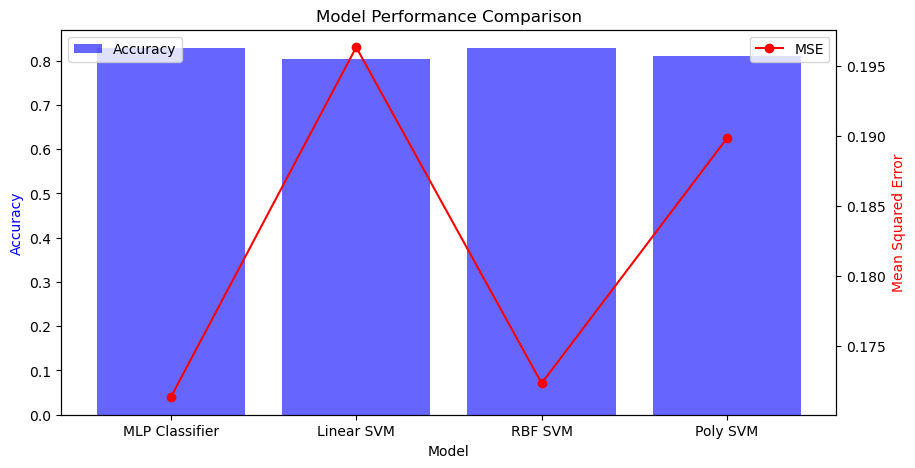


Model Performance Comparison:
MLP Classifier: Accuracy = 0.828667, MSE = 0.171333
Linear SVM: Accuracy = 0.803667, MSE = 0.196333
RBF SVM: Accuracy = 0.827667, MSE = 0.172333
Poly SVM: Accuracy = 0.810167, MSE = 0.189833


In [4]:
models = ['MLP Classifier'] + list(svm_acc.keys())
accuracies = [mlp_acc] + list(svm_acc.values())
mse_values = [mlp_mse] + list(svm_mse.values())

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.bar(models, accuracies, color='blue', alpha=0.6, label='Accuracy')
ax2.plot(models, mse_values, 'ro-', label='MSE')

ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy', color='blue')
ax2.set_ylabel('Mean Squared Error', color='red')
ax1.set_title('Model Performance Comparison')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

print("\nModel Performance Comparison:")
for model, acc, mse in zip(models, accuracies, mse_values):
    print(f"{model}: Accuracy = {acc:.6f}, MSE = {mse:.6f}")

#### Conclusion
- The MLP classifier achieved the highest accuracy at approximately 82.87%, likely due to its ability to model complex relationships in the data.
- The RBF SVM performed similarly to MLP, showing its strength in handling non-linear patterns, whereas the Linear SVM had lower accuracy due to its inability to capture complex decision boundaries.
- The polynomial SVM performed better than the linear model but did not surpass the RBF kernel, indicating that higher-degree transformations helped but were not the best fit for this dataset.
- The error rates (MSE) align with the accuracy trends, reinforcing the importance of choosing the right kernel for SVM and the impact of non-linearity in income classification.
